In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

In [55]:
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# dias_estada_grd = pd.read_excel("../data/processed/dias_estada_hospitalizados.xlsx")

canasta_hospitalizados_grd = pd.read_excel(

    "../data/processed/canasta_procedimientos_hospitalizados.xlsx"
)

Primero se quiere hacer un forecasting total de los egresos (sin desglose por diagnostico),
y tambien de los procedimientos necesarios totales


In [56]:
DIAGNOSTICO = "C341"

In [57]:
resumen_egresos_totales = (
    egresos_torax.query("DIAG1 == @DIAGNOSTICO and ANO_EGRESO == 2019")
    .groupby(["ANO_EGRESO"])["n_egresos"]
    .sum()
    .reset_index()
)
resumen_procedimientos_totales = canasta_hospitalizados_grd.query(
    "DIAGNOSTICO1 == 'C34.1' and ANIO_EGRESO == 2019"
)

In [58]:
EGRESOS_AUMENTADOS = 300
EGRESOS_2019 = resumen_egresos_totales.n_egresos.iloc[0]
AUMENTO_PROPORCIONAL = EGRESOS_AUMENTADOS / EGRESOS_2019

In [59]:
procedimientos_aumentados = resumen_procedimientos_totales.copy()
COLS_A_AUMENTAR = ["cantidad_procedimientos", "cantidad_pacientes_distintos"]

procedimientos_aumentados[COLS_A_AUMENTAR] = (
    procedimientos_aumentados[COLS_A_AUMENTAR] * AUMENTO_PROPORCIONAL
)

# 1. Forecasting

En este cuadernilllo se quiere predecir la cantidad de egresos hospitalarios que tendra
el Hospital del Torax a lo largo del tiempo. Ademas, se quire saber cuantos insumos se necesitaran
para atender tales casos.

In [66]:
resumen_egresos = (
    egresos_torax.groupby(["ANO_EGRESO", "MES_EGRESO", "DIA_EGRESO"])["n_egresos"].sum().to_frame()
)

<Axes: xlabel='ANO_EGRESO,MES_EGRESO,DIA_EGRESO'>

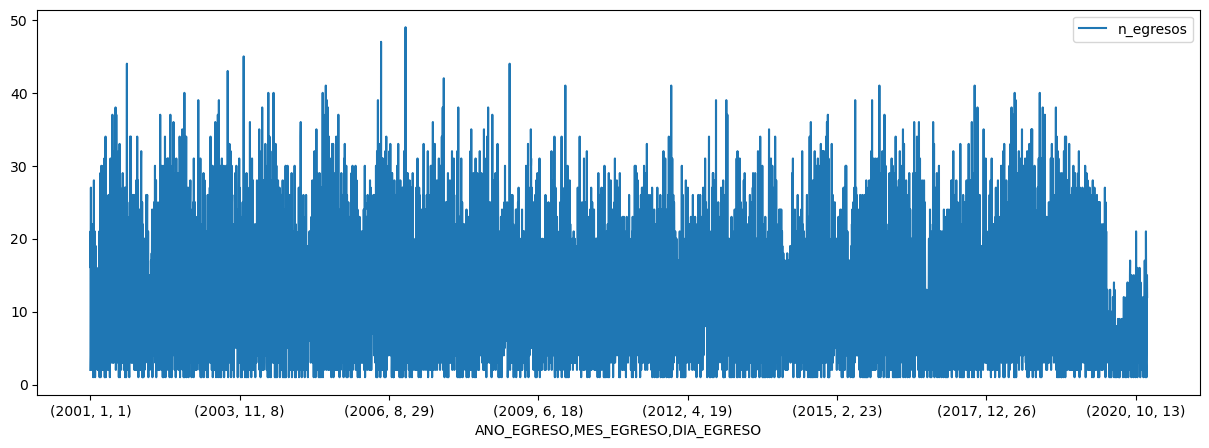

In [67]:
resumen_egresos.plot(figsize=(15, 5))

## Separacion en Train/Test

In [35]:
train = resumen_egresos[resumen_egresos.index < "01-01-2015"]
test = resumen_egresos[resumen_egresos.index >= "01-01-2015"]

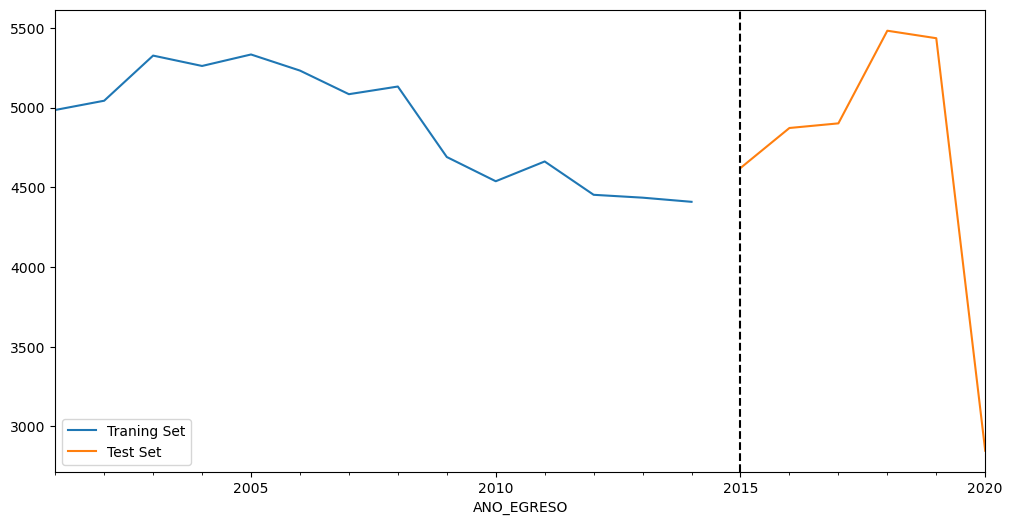

In [38]:
fig, axis = plt.subplots(1, 1, figsize=(12, 6))
train.plot(ax=axis, label="Traning")
test.plot(ax=axis, label="Test")
axis.axvline("01-01-2015", color="black", ls="--")
axis.legend(["Traning Set", "Test Set"])